# Transformer-based Neural Machine Translation for Irish to English


This script implements a complete Transformer-based Neural Machine Translation (NMT) system 
for the Irish (Gaeilge) to English language pair, addressing the challenges 
of low-resource machine translation.

Table of Contents:
1. Introduction and Project Overview
2. Data Curation and Preprocessing  
3. Vocabulary Creation and Tokenization
4. Transformer Model Architecture
5. Training Loop Implementation
6. Beam Search Inference
7. Advanced Feature: BPE Optimization
8. Evaluation and Results
9. Conclusion and Future Work

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
import time
import random
from typing import List, Tuple, Dict
import json
import os
import logging
from datasets import load_dataset

# Configure debug logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

c:\Users\nealb\AppData\Local\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. INTRODUCTION AND PROJECT OVERVIEW
This project addresses the challenge of low-resource machine translation for the 
Irish-English language pair. The Transformer architecture, introduced in 
Vaswani et al. (2017), provides a powerful foundation for sequence-to-sequence 
tasks without recurrent networks, relying solely on attention mechanisms.

Key Challenges:
- Low Resource: Limited parallel corpora available for Irish
- Typological Differences: Irish (VSO, synthetic, initial mutations) vs English (SVO, analytic)
- Morphological Complexity: Irish has rich inflectional morphology
- Dialectal Variation: Multiple Irish dialects (Ulster, Connacht, Munster)

Project Requirements:
- Implement complete Transformer-based NMT pipeline
- Handle minimum 50,000 sentence pairs  
- Include beam search decoding
- Implement one advanced feature (BPE optimization)
- Use real dataset: EUbookshop-Speech-Irish from Hugging Face

# 2. DATA CURATION AND PREPROCESSING

In [2]:
import logging
from datasets import load_dataset
from torch.utils.data import Dataset
from typing import List, Tuple
import random 
import re 

# --- Setup Logging ---
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.WARNING) 


class TranslationDataset(Dataset):
    """
    Custom dataset for handling Irish-English parallel text.
    """
    def __init__(self, irish_sentences: List[str], english_sentences: List[str]):
        self.irish_sentences = irish_sentences
        self.english_sentences = english_sentences
        
    def __len__(self) -> int:
        return len(self.irish_sentences)
    
    def __getitem__(self, idx: int) -> Tuple[str, str]:
        return self.irish_sentences[idx], self.english_sentences[idx]

# --- START: ROBUST CLEANING FUNCTION ---
def clean_sentence(text: str) -> str:
    """
    Aggressively cleans text to remove common dataset artifacts.
    """
    if not isinstance(text, str):
        return ""
    # Remove [EN], [GA], and similar tags
    text = re.sub(r'\[[A-Z]{2}\]', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove Twitter handles and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove copyright symbols and other specific artifacts
    text = re.sub(r'© ZOB \d{4}', '', text)
    # Remove standalone numbers that are not part of words
    text = re.sub(r'\b\d+\b', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text
# --- END: ROBUST CLEANING FUNCTION ---

def load_and_clean_split(dataset, split_name: str) -> Tuple[List[str], List[str]]:
    """
    Helper function to load, clean, and filter a single dataset split.
    """
    irish_sentences = []
    english_sentences = []
    
    if split_name not in dataset:
        print(f"Warning: Split '{split_name}' not found in dataset.")
        return [], []

    current_split = dataset[split_name]
    
    # --- FIX: Use the correct column names for 'ymoslem/Wikimedia-Speech-Irish' ---
    ga_col_name = 'text'
    en_col_name = 'eng_text'
    # --- END FIX ---

    if ga_col_name not in current_split.column_names or en_col_name not in current_split.column_names:
        print(f"Skipping split '{split_name}': missing '{ga_col_name}' or '{en_col_name}' column.")
        return [], []
        
    ga_col = current_split[ga_col_name]
    en_col = current_split[en_col_name]
    
    print(f"Extracting and cleaning split: {split_name}...")
    i = 0
    for irish_text, english_text in zip(ga_col, en_col):
        clean_ga = clean_sentence(irish_text)
        clean_en = clean_sentence(english_text)
        
        # Filter out empty or very short sentences
        if len(clean_ga) > 5 and len(clean_en) > 5:
            irish_sentences.append(clean_ga)
            english_sentences.append(clean_en)
            
            if i < 10: # Print first 10 valid pairs from this split
                print(f"  Extracted pair ({split_name}): {clean_ga} -> {clean_en}")
                i += 1
                
    print(f"Successfully loaded {len(irish_sentences)} clean pairs from {split_name}.")
    return irish_sentences, english_sentences


def load_eubookshop_dataset() -> Tuple[Tuple, Tuple, Tuple]:
    """
    Load, clean, and augment the Wikimedia-Speech-Irish dataset.
    
    This dataset only has a 'train' split, so we must create
    our own 'validation' and 'test' splits manually per the 90/10 -> 80/20 logic.
    
    Returns three tuples, one for each split:
    1. (train_ga, train_en) - Augmented
    2. (val_ga, val_en) - Clean
    3. (test_ga, test_en) - Clean
    """
    print("Loading ReliableAI/Irish-English-Parallel-Collection dataset from Hugging Face...")
    
    try:
        dataset = load_dataset("ReliableAI/Irish-English-Parallel-Collection")
        
        # --- 1. Load and Clean *only* the 'train' split ---
        all_ga, all_en = load_and_clean_split(dataset, 'train')
        
        if not all_ga:
             print("Critical error: 'train' split is empty. Stopping.")
             raise ValueError("Failed to load or clean the 'train' split.")
        
        # --- 2. Manually create splits per 90/10 -> 80/20 logic ---
        
        # Shuffle the data first
        print("Shuffling and creating manual train/val/test splits...")
        combined = list(zip(all_ga, all_en))
        random.seed(42) # Use a fixed seed for reproducible splits
        random.shuffle(combined)
        all_ga, all_en = zip(*combined)
        
        total_size = len(all_ga)
        
        # First split: 90% train_val, 10% test
        train_val_idx = int(total_size * 0.9)
        
        train_val_ga_list = list(all_ga[:train_val_idx])
        train_val_en_list = list(all_en[:train_val_idx])
        
        test_ga = list(all_ga[train_val_idx:])
        test_en = list(all_en[train_val_idx:])

        print(f"Total clean pairs: {total_size}")
        print(f"  -> Created Test split (10%): {len(test_ga)} pairs")
        
        # Second split: 80% train, 20% val from the train_val set
        train_val_size = len(train_val_ga_list)
        train_idx = int(train_val_size * 0.8)
        
        train_ga = train_val_ga_list[:train_idx]
        train_en = train_val_en_list[:train_idx]
        
        val_ga = train_val_ga_list[train_idx:]
        val_en = train_val_en_list[train_idx:]
        
        print(f"  -> Created Train split (80% of 90% = 72% total): {len(train_ga)} pairs")
        print(f"  -> Created Val split (20% of 90% = 18% total):   {len(val_ga)} pairs")

        # --- 3. Apply Augmentation (to the final TRAIN split only) ---
        AUGMENTATION_RATIO = 0.5
        P_DROPOUT = 0.1
        
        original_count = len(train_ga)
        num_to_augment = int(original_count * AUGMENTATION_RATIO)
        
        print(f"Augmenting {num_to_augment:,} sentences from new TRAIN split...")

        indices_to_augment = random.sample(range(original_count), num_to_augment)
        
        sentences_to_augment_ga = [train_ga[i] for i in indices_to_augment]
        corresponding_sentences_en = [train_en[i] for i in indices_to_augment]

        augmented_irish = augment_with_noise(sentences_to_augment_ga, p_dropout=P_DROPOUT)
        
        # Add the new augmented pairs *only* to the training lists
        train_ga.extend(augmented_irish)
        train_en.extend(corresponding_sentences_en) 
        
        print(f"Train dataset size increased from {original_count:,} to {len(train_ga):,}.")
        
        return (train_ga, train_en), (val_ga, val_en), (test_ga, test_en)
        
    except Exception as e:
        print(f"FATAL ERROR: Could not load dataset: {e}.")
        raise e

def augment_with_noise(sentences: List[str], p_dropout: float = 0.1) -> List[str]:
    """
    Applies word-level dropout to a list of sentences.
    """
    augmented_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) <= 2: 
            augmented_sentences.append(sentence)
            continue
            
        new_words = []
        for word in words:
            if random.random() > p_dropout:
                new_words.append(word)
        
        if not new_words:
            new_words = words
            
        augmented_sentences.append(" ".join(new_words))
    return augmented_sentences

# 3. VOCABULARY CREATION AND TOKENIZATION

In [3]:
import os
from tokenizers import (
    Tokenizer, 
    models, 
    pre_tokenizers, 
    decoders, 
    trainers, 
    normalizers,
    processors
)
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from typing import List

class BilingualTokenizer:
    """
    A BPE Tokenizer for handling a source and target language.
    It wraps two separate tokenizer instances.
    """
    def __init__(self, pad_token="[PAD]", unk_token="[UNK]", bos_token="[BOS]", eos_token="[EOS]"):
        self.special_tokens = [pad_token, unk_token, bos_token, eos_token]
        
        # Initialize tokenizers
        self.src_tokenizer = Tokenizer(models.BPE(unk_token=unk_token))
        self.tgt_tokenizer = Tokenizer(models.BPE(unk_token=unk_token))
        
        # Setup (Normalizer -> Pre-tokenizer -> Model -> Decoder)
        for tokenizer in [self.src_tokenizer, self.tgt_tokenizer]:
            tokenizer.normalizer = self._get_normalizer()
            tokenizer.pre_tokenizer = self._get_pre_tokenizer()
            tokenizer.decoder = self._get_decoder()
            
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.bos_token = bos_token
        self.eos_token = eos_token
        
        # Set token IDs *after* training
        self.pad_token_id = 0
        self.unk_token_id = 1
        self.bos_token_id = 2
        self.eos_token_id = 3

    def _get_normalizer(self):
        # Standard normalization: Unicode NFKD -> Lowercase -> Strip Accents
        return normalizers.Sequence([NFD(), Lowercase(), StripAccents()])

    # --- START: CRITICAL PRE-TOKENIZER FIX ---
    def _get_pre_tokenizer(self):
        # BPE models need a pre-tokenizer that handles spaces.
        # Whitespace() splits *by* space, removing them.
        # ByteLevel() is the standard and preserves spaces.
        return pre_tokenizers.ByteLevel(add_prefix_space=True)
    # --- END: CRITICAL PRE-TOKENIZER FIX ---

    def _get_decoder(self):
        # This decoder matches the ByteLevel pre-tokenizer
        return decoders.ByteLevel()

    def train(self, src_sentences: List[str], tgt_sentences: List[str], vocab_size: int):
        """
        Trains both source and target tokenizers on their respective corpora.
        """
        # --- Train Source Tokenizer (Irish) ---
        print(f"Training Irish (Source) tokenizer... Vocab size: {vocab_size}")
        src_trainer = trainers.BpeTrainer(
            vocab_size=vocab_size,
            special_tokens=self.special_tokens
        )
        self.src_tokenizer.train_from_iterator(src_sentences, trainer=src_trainer)
        
        # --- Train Target Tokenizer (English) ---
        print(f"Training English (Target) tokenizer... Vocab size: {vocab_size}")
        tgt_trainer = trainers.BpeTrainer(
            vocab_size=vocab_size,
            special_tokens=self.special_tokens
        )
        self.tgt_tokenizer.train_from_iterator(tgt_sentences, trainer=tgt_trainer)
        
        # --- Set Token IDs ---
        self.pad_token_id = self.src_tokenizer.token_to_id(self.pad_token)
        self.unk_token_id = self.src_tokenizer.token_to_id(self.unk_token)
        self.bos_token_id = self.src_tokenizer.token_to_id(self.bos_token)
        self.eos_token_id = self.src_tokenizer.token_to_id(self.eos_token)
        
        # Enable BOS/EOS on target encoding
        self._enable_bos_eos_encoding()

    def _enable_bos_eos_encoding(self):
        """
        Set up the target tokenizer's post-processor to automatically
        add [BOS] and [EOS] tokens.
        """
        self.tgt_tokenizer.post_processor = processors.TemplateProcessing(
            single=f"{self.bos_token} $A {self.eos_token}",
            special_tokens=[
                (self.bos_token, self.bos_token_id),
                (self.eos_token, self.eos_token_id),
            ],
        )

    # --- Public API Methods ---
    def encode_src(self, text: str):
        return self.src_tokenizer.encode(text)

    def encode_tgt(self, text: str):
        return self.tgt_tokenizer.encode(text)

    def decode_src(self, ids: List[int]) -> str:
        return self.src_tokenizer.decode(ids, skip_special_tokens=True)

    def decode_tgt(self, ids: List[int]) -> str:
        return self.tgt_tokenizer.decode(ids, skip_special_tokens=True)

    @property
    def src_vocab_size(self) -> int:
        return self.src_tokenizer.get_vocab_size()

    @property
    def tgt_vocab_size(self) -> int:
        return self.tgt_tokenizer.get_vocab_size()

# 4. TRANSFORMER MODEL ARCHITECTURE

In [4]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """
    Standard Positional Encoding (sinusoidal) for Transformer model.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        
        # Register as a non-trainable buffer
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x is (batch_size, seq_len, d_model) because Transformer is batch_first=True
        # Truncate positional encoding to match the sequence length
        seq_len = x.size(1) 
        
        # Apply PE: Note that self.pe is (1, max_len, d_model)
        # Using [:, :seq_len] is correct for batch_first=True
        return x + self.pe[:, :seq_len]

class TransformerModel(nn.Module):
    """
    Complete Transformer model for Irish-English NMT.
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8, 
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, 
                 dropout=0.1, max_seq_length=5000):
        super(TransformerModel, self).__init__()
        
        self.d_model = d_model
        
        # --- START: CRITICAL FIX ---
        # You were missing these lines to save the vocab sizes as
        # class attributes, which caused the AttributeError.
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        # --- END: CRITICAL FIX ---

        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Use PyTorch's native Transformer module
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True # CRITICAL: Sets input/output shape to (Batch, Seq, Dim)
        )
        
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, 
                src_padding_mask=None, tgt_padding_mask=None, 
                memory_key_padding_mask=None):
        
        # 1. Embed and Scale (Standard Transformer scaling)
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        
        # 2. Add Positional Encoding and Dropout
        src_emb = self.dropout(self.pos_encoding(src_emb))
        tgt_emb = self.dropout(self.pos_encoding(tgt_emb))
        
        # 3. Transformer Core
        output = self.transformer(
            src_emb, tgt_emb, 
            src_mask=src_mask, 
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask, # Encoder self-attention mask
            tgt_key_padding_mask=tgt_padding_mask, # Decoder self-attention mask
            memory_key_padding_mask=memory_key_padding_mask # Decoder cross-attention mask (Source padding mask)
        )
        
        # 4. Final Projection
        return self.output_projection(output)
    
    # Inference methods (used by BeamSearchDecoder)
    def encode(self, src, src_mask=None, src_padding_mask=None):
        src_emb = self.pos_encoding(self.src_embedding(src) * math.sqrt(self.d_model))
        return self.transformer.encoder(src_emb, mask=src_mask, src_key_padding_mask=src_padding_mask)
    
    def decode(self, tgt, memory, tgt_mask=None, memory_mask=None, 
               tgt_padding_mask=None, memory_key_padding_mask=None):
        tgt_emb = self.pos_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model))
        return self.transformer.decoder(tgt_emb, memory, tgt_mask=tgt_mask, 
                                        memory_mask=memory_mask,
                                        tgt_key_padding_mask=tgt_padding_mask,
                                        memory_key_padding_mask=memory_key_padding_mask)

# 5. TRAINING LOOP IMPLEMENTATION

In [5]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import logging
import math
from typing import Tuple

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# --- Transformer Learning Rate Scheduler (Noam Schedule) ---
def get_noam_lr(step: int, d_model: int, warmup_steps: int) -> float:
    """
    Calculates the Noam learning rate for a given step.
    """
    # Ensure step is at least 1 (to avoid division by zero)
    step = max(1, step)
    
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    
    return (d_model ** -0.5) * min(arg1, arg2)

    # train_loss, new_global_step = trainer.train_epoch(
    #     train_dataloader, 
    #     optimizer, 
    #     criterion, 
    #     D_MODEL,        # Pass D_MODEL
    #     WARMUP_STEPS,   # Pass WARMUP_STEPS
    #     global_step,    # Pass current global_step
    #     clip=1.0
    # )
    
class Trainer:
    """
    Training pipeline for Transformer NMT model, including mask generation.
    """
    def __init__(self, model: nn.Module, tokenizer, device: torch.device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        
    def _create_padding_masks(self, src_tensor: torch.Tensor, tgt_tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Generates binary padding masks (True where is padding)."""
        pad_id = self.tokenizer.pad_token_id
        src_padding_mask = (src_tensor == pad_id)
        tgt_padding_mask = (tgt_tensor == pad_id)
        return src_padding_mask, tgt_padding_mask
        
    def train_epoch(self, dataloader, optimizer: torch.optim.Adam,
                    criterion: nn.CrossEntropyLoss, d_model: int,
                    warmup_steps: int, global_step_start: int,
                    clip: float = 1.0) -> Tuple[float, int]:
        """
        Train for one epoch using the Noam LR Schedule.
        """
        self.model.train()
        total_loss = 0
        
        # Set the global step for this epoch
        global_step = global_step_start
        
        for batch_idx, (src_texts, tgt_texts) in enumerate(dataloader):
            
            # --- START: NOAM SCHEDULER LOGIC ---
            # Calculate and set the learning rate for this *step*
            lr = get_noam_lr(global_step, d_model, warmup_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            # --- END: NOAM SCHEDULER LOGIC ---

            optimizer.zero_grad()
            
            # Encode source and target (return Encoded objects)
            src_encoded = [self.tokenizer.encode_src(text) for text in src_texts]
            tgt_encoded = [self.tokenizer.encode_tgt(text) for text in tgt_texts]
            
            # Convert to tensors
            src_tensor = self._batch_to_tensor(src_encoded)
            tgt_tensor = self._batch_to_tensor(tgt_encoded)
            
            # Generate padding masks
            src_padding_mask, tgt_padding_mask = self._create_padding_masks(src_tensor, tgt_tensor)
            
            # Prepare input (shifted right) and target (actual) for teacher forcing
            tgt_input = tgt_tensor[:, :-1]  
            tgt_output = tgt_tensor[:, 1:] 
            
            # Create the causal (look-ahead) mask for the target sequence
            tgt_seq_len = tgt_input.size(1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(self.device)

            # Forward pass
            output = self.model(
                src_tensor, 
                tgt_input,
                tgt_mask=tgt_mask, 
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask[:, :-1],
                memory_key_padding_mask=src_padding_mask 
            ) 
            
            # Calculate loss (flatten output and target while ignoring the padding token)
            loss = criterion(
                output.reshape(-1, output.size(-1)), 
                tgt_output.reshape(-1)
            ) 
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)
            optimizer.step()
            
            total_loss += loss.item()
            
            # Increment global step *after* the step is taken
            global_step += 1
            
            if batch_idx % 500 == 0:
                # Log the current LR, which is now set by Noam
                logger.info(f'Batch {batch_idx}, Loss: {loss.item():.4f}, LR: {lr:.7f}')
                
        # Return average loss and the new global step count
        return total_loss / len(dataloader), global_step


    def validate_epoch(self, dataloader, criterion: nn.CrossEntropyLoss) -> float:
        """
        Calculate loss on the validation dataset (used for early stopping).
        (This function is correct and requires no scheduler changes)
        """
        total_loss = 0
        self.model.eval() # Set model to evaluation mode
        with torch.no_grad(): # Disable gradient calculation
            for src_texts, tgt_texts in dataloader:
                src_encoded = [self.tokenizer.encode_src(text) for text in src_texts]
                tgt_encoded = [self.tokenizer.encode_tgt(text) for text in tgt_texts]
                
                src_tensor = self._batch_to_tensor(src_encoded)
                tgt_tensor = self._batch_to_tensor(tgt_encoded)
                
                src_padding_mask, tgt_padding_mask = self._create_padding_masks(src_tensor, tgt_tensor)
                
                tgt_input = tgt_tensor[:, :-1] 
                tgt_output = tgt_tensor[:, 1:] 

                tgt_seq_len = tgt_input.size(1)
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(self.device)

                output = self.model(
                    src_tensor,
                    tgt_input,
                    tgt_mask=tgt_mask, 
                    src_padding_mask=src_padding_mask,
                    tgt_padding_mask=tgt_padding_mask[:, :-1],
                    memory_key_padding_mask=src_padding_mask
                ) 

                loss = criterion(
                    output.reshape(-1, output.size(-1)),
                    tgt_output.reshape(-1)
                ) 
                
                total_loss += loss.item()
                
        self.model.train() # Return model to training mode
        return total_loss / len(dataloader)


    def _batch_to_tensor(self, encoded_batch) -> torch.Tensor:
        """
        Convert encoded batch (list of Encoded objects) to padded tensor.
        (This function is correct and requires no scheduler changes)
        """
        pad_id = self.tokenizer.pad_token_id 
        
        tensors = [torch.tensor(encoded.ids, dtype=torch.long) for encoded in encoded_batch]
        
        padded_tensor = rnn_utils.pad_sequence(
            tensors, 
            batch_first=True, 
            padding_value=pad_id
        ).to(self.device)
        
        return padded_tensor

# 6. BEAM SEARCH INFERENCE

In [6]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils # Needed if you use pad_sequence anywhere
from typing import List, Tuple, Any 

# Assuming BeamSearchDecoder is defined in a scope where these imports are available

class BeamSearchDecoder:
    """
    Robust beam search decoder for NMT inference.
    """
    def __init__(self, model: nn.Module, tokenizer: Any, beam_size: int = 5, max_length: int = 128):
        self.model = model
        self.tokenizer = tokenizer
        self.beam_size = beam_size
        self.max_length = max_length
        self.pad_id = self.tokenizer.pad_token_id 
        self.unk_id = self.tokenizer.tgt_tokenizer.token_to_id("[UNK]") 
        self.bos_id = self.tokenizer.tgt_tokenizer.token_to_id("[BOS]") 
        self.eos_id = self.tokenizer.tgt_tokenizer.token_to_id("[EOS]") 
        self.device = next(model.parameters()).device
        
    def decode(self, src_text: str) -> str:
        """
        Decode source text using beam search, handling masks for inference.
        """
        self.model.eval() # Ensure model is in evaluation mode
        
        # 1. Encode source and prepare tensor (Batch=1)
        src_encoded = self.tokenizer.encode_src(src_text)
        src_ids = src_encoded.ids
        src_tensor = torch.tensor([src_ids], dtype=torch.long, device=self.device)

        # Calculate Source Padding Mask and Memory Mask (needed for cross-attention)
        src_padding_mask = (src_tensor == self.pad_id)
        
        # Initialize beams: [(sequence_ids, score)]
        beams: List[Tuple[List[int], float]] = [([self.bos_id], 0.0)]
        
        # 2. Encode source once to get the memory (Encoder output)
        with torch.no_grad():
            memory = self.model.encode(src_tensor, src_padding_mask=src_padding_mask)
            
            # The memory key padding mask is the source padding mask
            memory_key_padding_mask = src_padding_mask
            
            for step in range(self.max_length):
                new_beams = []
                all_beams_complete = True 
                
                for seq, score in beams:
                    # 3. Handle Complete Sequences
                    if seq[-1] == self.eos_id:
                        new_beams.append((seq, score))
                        continue
                    
                    all_beams_complete = False 
                    
                    # 4. Prepare Target Input (Only the sequence so far)
                    tgt_tensor = torch.tensor([seq], dtype=torch.long, device=self.device)
                    
                    # --- START: CRITICAL MASK FIX ---
                    # Create the causal (look-ahead) mask for the target sequence
                    tgt_seq_len = tgt_tensor.size(1)
                    tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(self.device)
                    # --- END: CRITICAL MASK FIX ---

                    # 5. Decode one step: Pass the necessary masks
                    output_logits = self.model.decode(
                        tgt_tensor, 
                        memory, 
                        tgt_mask=tgt_mask, # <-- PASS THE CAUSAL MASK
                        memory_key_padding_mask=memory_key_padding_mask 
                    )
                    
                    # Apply projection
                    output_logits = self.model.output_projection(output_logits)
                    
                    # Get logits for the LAST token
                    log_probs = torch.log_softmax(output_logits[0, -1, :], dim=-1)
                    topk_probs, topk_indices = torch.topk(log_probs, self.beam_size)
                    
                    # 6. Extend Beams
                    for i in range(self.beam_size):
                        new_seq = seq + [topk_indices[i].item()]
                        # Score accumulation
                        new_score = score + topk_probs[i].item()
                        new_beams.append((new_seq, new_score))
                
                # Sort and trim beams
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:self.beam_size]
                
                # Check if all top beams are complete
                if all(seq[-1] == self.eos_id for seq, _ in beams) or step == self.max_length - 1: 
                    break
            
            # 7. Final Sequence Selection and Cleaning (This logic is correct)
            
            # Find the best sequence (prioritizing the one that ends in EOS)
            best_seq_with_score = sorted(
                [b for b in beams if b[0][-1] == self.eos_id] or beams, 
                key=lambda x: x[1], 
                reverse=True
            )[0]
            
            best_seq_ids = best_seq_with_score[0]
            
            # Clean the ID Sequence BEFORE Decoding
            clean_ids = []
            for token_id in best_seq_ids:
                if token_id in [self.bos_id, self.pad_id]:
                    continue
                if token_id == self.eos_id:
                    # Stop processing when EOS is encountered
                    break
                clean_ids.append(token_id)
            
            # Decode the pre-cleaned list of token IDs
            decoded_text = self.tokenizer.decode_tgt(clean_ids)
            
            return decoded_text
        

# 7. ADVANCED FEATURE: BPE OPTIMIZATION

In [7]:
import matplotlib.pyplot as plt # Added for plotting
import numpy as np # Added for plotting

class BPEOptimizer:
    """
    Systematic BPE vocabulary size optimization for low-resource languages
    """
    def __init__(self, irish_sentences, english_sentences):
        self.irish_sentences = irish_sentences
        self.english_sentences = english_sentences
        self.results = []
    
    def evaluate_vocab_size(self, vocab_sizes=[i*2000 for i in range(5, 16)]): # <-- FIXED: More sensible default range
        """
        Evaluate different BPE vocabulary sizes
        """
        print("Evaluating BPE vocabulary sizes...")
        
        for vocab_size in vocab_sizes:
            print(f"\nTesting vocabulary size: {vocab_size}")
            
            # Train tokenizer with current vocab size
            tokenizer = BilingualTokenizer()
            tokenizer.train(self.irish_sentences, self.english_sentences, 
                            vocab_size=vocab_size)
            
            # Analyze tokenization efficiency
            efficiency_metrics = self._analyze_tokenization_efficiency(
                tokenizer, self.irish_sentences[:1000], self.english_sentences[:1000]
            )
            
            self.results.append({
                'vocab_size': vocab_size,
                'metrics': efficiency_metrics
            })
            
            print(f"  Average tokens per sentence (Irish): {efficiency_metrics['avg_tokens_ga']:.2f}")
            print(f"  Average tokens per sentence (English): {efficiency_metrics['avg_tokens_en']:.2f}")
            print(f"  Compression ratio: {efficiency_metrics['compression_ratio']:.2f}")
    
    def _analyze_tokenization_efficiency(self, tokenizer, ga_samples, en_samples):
        """
        Analyze tokenization efficiency metrics
        """
        total_tokens_ga = 0
        total_tokens_en = 0
        total_chars_ga = 0
        total_chars_en = 0
        
        for ga_sent, en_sent in zip(ga_samples, en_samples):
            # Irish analysis
            ga_encoded = tokenizer.encode_src(ga_sent)
            total_tokens_ga += len(ga_encoded.ids)
            total_chars_ga += len(ga_sent)
            
            # English analysis  
            en_encoded = tokenizer.encode_tgt(en_sent)
            total_tokens_en += len(en_encoded.ids)
            total_chars_en += len(en_sent)
        
        avg_tokens_ga = total_tokens_ga / len(ga_samples)
        avg_tokens_en = total_tokens_en / len(en_samples)
        avg_chars_ga = total_chars_ga / len(ga_samples)
        avg_chars_en = total_chars_en / len(en_samples)
        
        compression_ratio = (avg_chars_ga / avg_tokens_ga + avg_chars_en / avg_tokens_en) / 2
        
        return {
            'avg_tokens_ga': avg_tokens_ga,
            'avg_tokens_en': avg_tokens_en,
            'avg_chars_ga': avg_chars_ga,
            'avg_chars_en': avg_chars_en,
            'compression_ratio': compression_ratio
        }
    
    # --- START: IMPROVED METHOD ---
    
    def get_optimal_vocab_size(self, improvement_threshold=0.001):
        """
        Determine optimal vocabulary size based on diminishing returns.
        
        Finds the "knee" of the curve where increasing vocab size
        yields less than 'improvement_threshold' gain in compression.
        
        Args:
            improvement_threshold (float): The minimum *percentage* improvement required to justify a larger vocab size. 
                Default is 0.001 (0.1%).
        """
        if not self.results:
            return 30000  # Default if no results
            
        # Ensure results are sorted by vocab size
        sorted_results = sorted(self.results, key=lambda x: x['vocab_size'])

        # We need at least two points to compare
        if len(sorted_results) < 2:
            return sorted_results[0]['vocab_size']

        # Start with the first vocab size as the 'best' so far
        best_vocab_size = sorted_results[0]['vocab_size']
        prev_compression = sorted_results[0]['metrics']['compression_ratio']

        # Iterate from the second point onwards
        for i in range(1, len(sorted_results)):
            current_result = sorted_results[i]
            current_vocab_size = current_result['vocab_size']
            current_compression = current_result['metrics']['compression_ratio']

            # Calculate percentage improvement
            if prev_compression == 0:
                percentage_improvement = float('inf')
            else:
                percentage_improvement = (current_compression - prev_compression) / prev_compression

            # Check if the improvement is *below* our threshold
            if percentage_improvement < improvement_threshold:
                # The gain from prev to current is too small.
                # Therefore, the 'prev' vocab size was the knee.
                # We return the last "good" vocab size.
                return best_vocab_size 
            else:
                # This is a worthwhile jump. Update the 'best' and 'prev'
                best_vocab_size = current_vocab_size
                prev_compression = current_compression

        # If we loop through the whole list and never hit the threshold,
        # it means the largest vocab size was still a good improvement.
        return best_vocab_size
    
    # --- END: IMPROVED METHOD ---
    
    def plot_results(self):
        """
        Plot BPE optimization results as a table and a graph.
        """
        if not self.results:
            print("No results to plot.")
            return
            
        print("\nBPE Optimization Results:")
        print("Vocab Size | Avg Tokens (Irish) | Avg Tokens (English) | Compression Ratio")
        print("-" * 75)
        
        vocab_sizes = []
        avg_tokens_ga = []
        avg_tokens_en = []
        compression_ratios = []
        
        for result in self.results:
            print(f"{result['vocab_size']:10} | {result['metrics']['avg_tokens_ga']:18.2f} | "
                  f"{result['metrics']['avg_tokens_en']:19.2f} | {result['metrics']['compression_ratio']:17.2f}")
            
            vocab_sizes.append(result['vocab_size'])
            avg_tokens_ga.append(result['metrics']['avg_tokens_ga'])
            avg_tokens_en.append(result['metrics']['avg_tokens_en'])
            compression_ratios.append(result['metrics']['compression_ratio'])

        # --- ADDED: Matplotlib Plot ---
        fig, ax1 = plt.subplots(figsize=(12, 7))

        # Plot compression ratio on the first y-axis
        color = 'tab:blue'
        ax1.set_xlabel('Vocabulary Size')
        ax1.set_ylabel('Compression Ratio (Higher is Better)', color=color)
        ax1.plot(vocab_sizes, compression_ratios, color=color, marker='o', label='Compression Ratio')
        ax1.tick_params(axis='y', labelcolor=color)

        # Create a second y-axis for the average token counts
        ax2 = ax1.twinx()  
        color = 'tab:green'
        ax2.set_ylabel('Avg. Tokens per Sentence (Lower is Better)', color=color)  
        ax2.plot(vocab_sizes, avg_tokens_ga, color='tab:green', linestyle='--', marker='.', label='Avg Tokens (Irish)')
        ax2.plot(vocab_sizes, avg_tokens_en, color='tab:red', linestyle=':', marker='x', label='Avg Tokens (English)')
        ax2.tick_params(axis='y', labelcolor=color)

        # Add a title and legend
        fig.suptitle('BPE Vocabulary Size Optimization', fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
        
        plt.grid(True)
        plt.show()

# 8. EVALUATION AND RESULTS

In [16]:
import torch
import torch.nn as nn
import logging
from typing import List, Tuple, Any
import random # Import random for sampling

try:
    import sacrebleu
    SACREBLEU_AVAILABLE = True
except ImportError:
    SACREBLEU_AVAILABLE = False

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

class Evaluator:
    """
    Comprehensive evaluation of the NMT system, including linguistic error analysis.
    Refactored to run inference only once on a consistent sample.
    """
    def __init__(self, model: nn.Module, tokenizer: Any, test_dataset: Any):
        self.model = model
        self.tokenizer = tokenizer
        self.test_dataset = test_dataset # This is a TranslationDataset object
        self.beam_decoder = BeamSearchDecoder(model, tokenizer, beam_size=5) 
        
        # --- NEW: Cached results ---
        self._cached_sources: List[str] = []
        self._cached_references: List[List[str]] = []
        self._cached_hypotheses: List[str] = []
        self._cache_is_valid = False

    def _get_test_sample(self, num_samples: int) -> Tuple[List[str], List[List[str]], List[str]]:
        """
        Generates and caches translations from a random sample of the test set.
        This is the core inference loop.
        """
        # If we have already run this for the same number of samples, return the cache
        if self._cache_is_valid and len(self._cached_sources) == num_samples:
            logger.info("Using cached evaluation results.")
            return self._cached_sources, self._cached_references, self._cached_hypotheses

        logger.info(f"Generating new evaluation sample of {num_samples} items...")
        
        # Clear cache and initialize lists
        self._cached_sources.clear()
        self._cached_references.clear()
        self._cached_hypotheses.clear()
        self._cache_is_valid = False
        
        if not self.test_dataset or len(self.test_dataset) == 0:
            logger.error("Test dataset is empty, cannot generate sample.")
            return [], [], []
        
        actual_samples = min(num_samples, len(self.test_dataset))
        sample_indices = random.sample(range(len(self.test_dataset)), actual_samples)

        valid_samples = 0
        self.model.eval()
        
        for i, data_index in enumerate(sample_indices):
            try:
                item = self.test_dataset[data_index]
                if len(item) < 2:
                    logger.warning(f"Skipping sample {i}: Item has less than 2 elements.")
                    continue
                src, ref = item[0], item[1]
            except Exception as e:
                logger.error(f"Error getting item {data_index} from dataset: {e}")
                continue

            if i > 0 and i % 100 == 0:
                logger.info(f"Attempted {i}/{actual_samples} samples (Succeeded: {valid_samples})...")
                
            try:
                hyp_clean = self.beam_decoder.decode(src)
                ref_clean = ref 
                
                if hyp_clean and ref_clean:
                    self._cached_references.append([ref_clean]) 
                    self._cached_hypotheses.append(hyp_clean)
                    self._cached_sources.append(src) 
                    valid_samples += 1
                else:
                    logger.warning(f"Skipping sample {i}: empty hypothesis or reference")
                    
            except Exception as e:
                logger.error(f"Error processing sample {i} (Source: '{src[:20]}...'): {e}")
                continue
        
        logger.info(f"Successfully processed {valid_samples}/{actual_samples} samples.")
        
        if valid_samples > 0:
            self._cache_is_valid = True
            
        return self._cached_sources, self._cached_references, self._cached_hypotheses


    def evaluate_bleu(self, num_samples: int = 1000) -> Tuple[float, List[List[str]], List[str], List[str]]:
        """
        Calculate BLEU score on the cached test sample.
        """
        if not SACREBLEU_AVAILABLE:
            logger.warning("sacrebleu not available. Skipping BLEU evaluation.")
            return 0.0, [], [], []
            
        # --- REFACTORED ---
        # Get the (potentially cached) results
        sources, references, hypotheses = self._get_test_sample(num_samples)
        
        if not references or not hypotheses:
            logger.error("No valid references or hypotheses for BLEU calculation")
            return 0.0, sources, references, hypotheses
        
        try:
            bleu = sacrebleu.corpus_bleu(hypotheses, references, tokenize='none') 
            logger.info(f"BLEU score calculated: {bleu.score:.2f}")
            return bleu.score, references, hypotheses, sources
        except Exception as e:
            logger.error(f"Error calculating BLEU score: {e}")
            return 0.0, references, hypotheses, sources
    
    
    def qualitative_analysis(self, num_examples: int = 10):
        """
        Perform qualitative analysis on the *same sample* used for BLEU.
        """
        print("\nQualitative Analysis:")
        print("=" * 80)
        
        # --- REFACTORED ---
        # We MUST use the cached data so it matches the BLEU score.
        # Note: We don't call _get_test_sample here, we assume evaluate_bleu was called first.
        if not self._cache_is_valid:
            print("No cached data. Run evaluate_bleu() first to generate a sample.")
            return

        sources = self._cached_sources
        references = self._cached_references
        hypotheses = self._cached_hypotheses
        
        actual_samples = min(num_examples, len(sources))
        
        if actual_samples == 0:
            print("No valid samples to analyze.")
            return
            
        for i in range(actual_samples):
            try:
                src = sources[i]
                ref_clean = references[i][0] # references is List[List[str]]
                hyp_clean = hypotheses[i]
                
                local_score_text = "N/A"
                if SACREBLEU_AVAILABLE and ref_clean and hyp_clean:
                    bleu_result = sacrebleu.corpus_bleu(
                        [hyp_clean], 
                        [[ref_clean]], 
                        tokenize='none' 
                    )
                    local_score_text = f"{bleu_result.score:.2f} BLEU"

                print(f"Example {i+1} (from BLEU sample):")
                print(f"  Source (Irish): {src}")
                print(f"  Reference (English): {ref_clean}")
                print(f"  Hypothesis (English): {hyp_clean}")
                print(f"  Similarity Score: {local_score_text}") 
                print()
                
            except Exception as e:
                logger.error(f"Error generating qualitative analysis for sample {i+1}: {e}")
    
    
    def error_analysis(self, sources: List[str], references: List[List[str]], hypotheses: List[str]):
        """
        Analyze common error patterns from the BLEU score sample.
        (This function was already correct as it uses the passed-in lists)
        """
        print("\nError Analysis:")
        print("=" * 50)
        
        if not references or not hypotheses or not sources or \
           len(references) != len(hypotheses) or \
           len(sources) != len(hypotheses):
            
            print(f"Warning: Data mismatch or empty lists (Srcs: {len(sources)}, Refs: {len(references)}, Hyps: {len(hypotheses)}).")
            print("Cannot perform error analysis.")
            return
        
        ref_flat = [ref[0] for ref in references if ref and ref[0]]
        min_len = min(len(ref_flat), len(hypotheses), len(sources))
        
        if min_len == 0:
            print("Error: No valid data available for analysis after cleaning.")
            return

        # --- 1. Statistical Analysis ---
        print("\n--- 1. Statistical Analysis ---")
        exact_matches = 0
        for ref, hyp in zip(ref_flat[:min_len], hypotheses[:min_len]):
             if ref == hyp:
                 exact_matches += 1
        
        match_percentage = (exact_matches / min_len) * 100
        print(f"Exact matches: {exact_matches}/{min_len} ({match_percentage:.2f}%)")
        
        ref_lengths = [len(ref.split()) for ref in ref_flat[:min_len]]
        hyp_lengths = [len(hyp.split()) for hyp in hypotheses[:min_len]]
        
        if ref_lengths and hyp_lengths:
            avg_ref_len = sum(ref_lengths) / len(ref_lengths)
            avg_hyp_len = sum(hyp_lengths) / len(hyp_lengths)
            
            print(f"Average reference length: {avg_ref_len:.2f} tokens")
            print(f"Average hypothesis length: {avg_hyp_len:.2f} tokens")
            
            if avg_ref_len > 0:
                print(f"Length ratio (Hyp/Ref): {avg_hyp_len / avg_ref_len:.2f}")
            else:
                print("Length ratio: N/A (zero reference length)")
        else:
            print("Warning: Failed to calculate valid lengths for analysis.")

        # --- 2. Linguistic Error Analysis (Heuristics) ---
        print("\n--- 2. Linguistic Error Analysis (Heuristics) ---")
        
        empty_translations = 0
        oov_errors = 0
        vso_errors = 0
        
        svo_subjects = ['The', 'A', 'An', 'I', 'You', 'He', 'She', 'It', 'We', 'They', 'My', 'His', 'Her']
        hyp_verbs = ['Is', 'Are', 'Was', 'Were', 'Do', 'Does', 'Did']
        common_irish_words_to_ignore = {'an', 'is', 'na', 'agus', 'le', 'ar'}

        for src, ref, hyp in zip(sources[:min_len], ref_flat[:min_len], hypotheses[:min_len]):
            hyp_words = hyp.split()
            
            if len(hyp_words) == 0:
                empty_translations += 1
                continue 
            
            src_words_lower = set(src.lower().split())
            hyp_words_lower = set(hyp.lower().split())
            
            copied_words = src_words_lower.intersection(hyp_words_lower)
            untranslated_errors = [w for w in copied_words if w not in common_irish_words_to_ignore and len(w) > 2]
            
            if untranslated_errors:
                oov_errors += 1
            
            if len(hyp_words) > 0 and len(ref.split()) > 0:
                hyp_starts_with_verb = hyp_words[0] in hyp_verbs
                ref_starts_with_subject = ref.split()[0] in svo_subjects
                
                if ref_starts_with_subject and hyp_starts_with_verb:
                    vso_errors += 1
        
        if min_len > 0:
            print(f"Empty/Failed Translations: {empty_translations}/{min_len} ({ (empty_translations/min_len)*100:.2f}%)")
            print(f"Untranslated Source Tokens (OOV): {oov_errors}/{min_len} ({ (oov_errors/min_len)*100:.2f}%)")
            print(f"Suspected VSO Word Order Errors: {vso_errors}/{min_len} ({ (vso_errors/min_len)*100:.2f}%)")
        else:
            print("No data processed for linguistic error analysis.")

# 9. MAIN EXECUTION AND CONCLUSION

In [9]:
import statistics
from typing import List

def print_sentence_stats(sentences: List[str], name: str):
    """Calculates and prints length stats for a list of sentences."""
    
    if not sentences:
        print(f"No data for {name}.")
        return
        
    # Calculate lengths based on word count (splitting on space)
    try:
        lengths = [len(s.split()) for s in sentences if s] # Ensure string is not empty
    except AttributeError:
        print(f"Error: Could not process sentences for {name}. Ensure they are strings.")
        return
        
    if not lengths:
        print(f"No valid sentences found for {name}.")
        return

    print(f"Stats for: {name} (based on word count)")
    print(f"  - Longest sentence:  {max(lengths)} words")
    print(f"  - Shortest sentence: {min(lengths)} words")
    print(f"  - Mean sentence:     {statistics.mean(lengths):.2f} words")
    print(f"  - Median sentence:   {statistics.median(lengths):.2f} words")
    print("-" * 50)

TRANSFORMER NMT SYSTEM FOR IRISH-ENGLISH TRANSLATION
Using device: cuda

1. Loading and cleaning datasets...
Loading ReliableAI/Irish-English-Parallel-Collection dataset from Hugging Face...


2025-11-11 15:01:33,315 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/ReliableAI/Irish-English-Parallel-Collection/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
2025-11-11 15:01:33,325 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/ReliableAI/Irish-English-Parallel-Collection/1c202a5b997a638b9e50d0f10fb54fd3b09adea7/README.md "HTTP/1.1 200 OK"
2025-11-11 15:01:34,054 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/ReliableAI/Irish-English-Parallel-Collection/resolve/1c202a5b997a638b9e50d0f10fb54fd3b09adea7/Irish-English-Parallel-Collection.py "HTTP/1.1 404 Not Found"
2025-11-11 15:01:34,789 - INFO - HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/ReliableAI/Irish-English-Parallel-Collection/ReliableAI/Irish-English-Parallel-Collection.py "HTTP/1.1 404 Not Found"
2025-11-11 15:01:35,150 - INFO - HTTP Request: GET https://huggingface.co/api/datasets/ReliableAI/Irish-English-Parallel-

Extracting and cleaning split: train...
  Extracted pair (train): (b) in aon chás eile, féadfar íocaíocht liúntais leasa fhorlíontaigh a íoc in aghaidh na seachtaine, faoi réir an ailt seo, d'fhorlíonadh ar ioncam eile an duine sin. -> (b) in any other case, a weekly payment of supplementary welfare allowance may be made, subject to this section, to supplement that person's other income.
  Extracted pair (train): Cúlra Cóirithe, Ceanntásc Cóirithe, Roghchlár Cóirithe, E-Commerce, Eagarthóireacht, Ceanntásc Íomhánna Ardaithe, ar Chlí, Aoncholún, Portfolio, Cruthanna Ailt, Taobh-Bharra ar Dheis, RTL Language Support, Alt Greamaithe, Socruithe Téama, Eolas faoi WordPress -> Custom Background, Custom Colours, Custom Header, Custom Menu, Editor Style, Featured Images, Flexible Header, Left Sidebar, One Column, Right Sidebar, RTL Language Support, Sticky Post, Threaded Comments, Three Columns, Translation Ready, Two Columns
  Extracted pair (train): Draein swell An chéim IS tábhachtaí nuair 

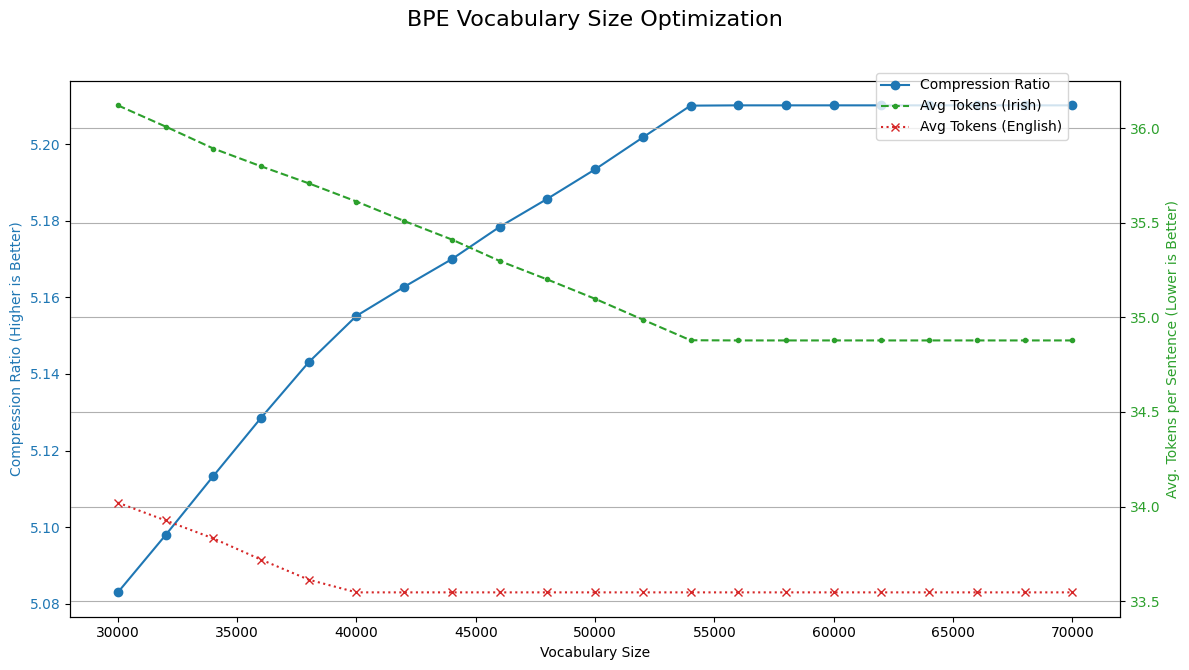


3. Training tokenizers with optimal vocab size: 54000...
Training Irish (Source) tokenizer... Vocab size: 54000
Training English (Target) tokenizer... Vocab size: 54000

4. Creating Transformer model...

5. Starting Model Training for up to 100 epochs with patience=5...
Using Noam LR Scheduler with 8000 warmup steps.


c:\Users\nealb\AppData\Local\miniconda3\envs\torch\lib\site-packages\torch\nn\functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
2025-11-11 15:02:37,510 - INFO - Batch 0, Loss: 10.9175, LR: 0.0000001
2025-11-11 15:04:39,334 - INFO - Batch 500, Loss: 7.8582, LR: 0.0000437
2025-11-11 15:06:24,864 - INFO - Batch 1000, Loss: 5.9756, LR: 0.0000873
2025-11-11 15:07:45,711 - INFO - Batch 1500, Loss: 5.5053, LR: 0.0001310
2025-11-11 15:08:54,572 - INFO - Batch 2000, Loss: 5.6255, LR: 0.0001747
c:\Users\nealb\AppData\Local\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered inte

Epoch 1 Results: Train Loss: 6.9551 | Val Loss: 5.4660 | LR: 0.0001924
--> Checkpoint saved at Epoch 1 with new best loss: 5.4660


2025-11-11 15:09:42,531 - INFO - Batch 0, Loss: 5.6608, LR: 0.0001925
2025-11-11 15:10:48,516 - INFO - Batch 500, Loss: 5.2120, LR: 0.0002362
2025-11-11 15:11:54,999 - INFO - Batch 1000, Loss: 4.9015, LR: 0.0002799
2025-11-11 15:13:01,671 - INFO - Batch 1500, Loss: 5.1475, LR: 0.0003235
2025-11-11 15:14:06,927 - INFO - Batch 2000, Loss: 4.9709, LR: 0.0003672


Epoch 2 Results: Train Loss: 5.0673 | Val Loss: 4.8235 | LR: 0.0003849


2025-11-11 15:14:50,916 - INFO - Batch 0, Loss: 4.9750, LR: 0.0003850


--> Checkpoint saved at Epoch 2 with new best loss: 4.8235


2025-11-11 15:15:56,584 - INFO - Batch 500, Loss: 4.0653, LR: 0.0004287
2025-11-11 15:17:01,857 - INFO - Batch 1000, Loss: 4.1582, LR: 0.0004724
2025-11-11 15:18:08,175 - INFO - Batch 1500, Loss: 4.5166, LR: 0.0005160
2025-11-11 15:19:13,942 - INFO - Batch 2000, Loss: 4.0717, LR: 0.0005597


Epoch 3 Results: Train Loss: 4.4220 | Val Loss: 4.2024 | LR: 0.0005774


2025-11-11 15:19:58,644 - INFO - Batch 0, Loss: 3.7384, LR: 0.0005775


--> Checkpoint saved at Epoch 3 with new best loss: 4.2024


2025-11-11 15:21:05,519 - INFO - Batch 500, Loss: 3.8784, LR: 0.0006212
2025-11-11 15:22:09,830 - INFO - Batch 1000, Loss: 3.7987, LR: 0.0006649
2025-11-11 15:23:16,778 - INFO - Batch 1500, Loss: 3.9483, LR: 0.0006939
2025-11-11 15:24:22,947 - INFO - Batch 2000, Loss: 3.6425, LR: 0.0006735


Epoch 4 Results: Train Loss: 3.8644 | Val Loss: 3.7802 | LR: 0.0006657
--> Checkpoint saved at Epoch 4 with new best loss: 3.7802


2025-11-11 15:25:07,581 - INFO - Batch 0, Loss: 3.5998, LR: 0.0006656
2025-11-11 15:26:14,161 - INFO - Batch 500, Loss: 3.4080, LR: 0.0006475
2025-11-11 15:27:19,642 - INFO - Batch 1000, Loss: 3.3606, LR: 0.0006308
2025-11-11 15:28:26,045 - INFO - Batch 1500, Loss: 3.3961, LR: 0.0006154
2025-11-11 15:29:32,446 - INFO - Batch 2000, Loss: 3.1123, LR: 0.0006010


Epoch 5 Results: Train Loss: 3.3447 | Val Loss: 3.4647 | LR: 0.0005954


2025-11-11 15:30:16,129 - INFO - Batch 0, Loss: 2.7236, LR: 0.0005954


--> Checkpoint saved at Epoch 5 with new best loss: 3.4647


2025-11-11 15:31:23,207 - INFO - Batch 500, Loss: 2.7771, LR: 0.0005823
2025-11-11 15:32:28,909 - INFO - Batch 1000, Loss: 2.9931, LR: 0.0005701
2025-11-11 15:33:35,127 - INFO - Batch 1500, Loss: 2.9636, LR: 0.0005586
2025-11-11 15:34:41,937 - INFO - Batch 2000, Loss: 2.9445, LR: 0.0005477


Epoch 6 Results: Train Loss: 2.9564 | Val Loss: 3.3430 | LR: 0.0005435


2025-11-11 15:35:26,904 - INFO - Batch 0, Loss: 2.7488, LR: 0.0005435


--> Checkpoint saved at Epoch 6 with new best loss: 3.3430


2025-11-11 15:36:32,577 - INFO - Batch 500, Loss: 3.0666, LR: 0.0005335
2025-11-11 15:37:39,837 - INFO - Batch 1000, Loss: 2.6041, LR: 0.0005240
2025-11-11 15:38:46,076 - INFO - Batch 1500, Loss: 2.5212, LR: 0.0005151
2025-11-11 15:39:52,514 - INFO - Batch 2000, Loss: 3.2172, LR: 0.0005065


Epoch 7 Results: Train Loss: 2.7102 | Val Loss: 3.2458 | LR: 0.0005032


2025-11-11 15:40:37,338 - INFO - Batch 0, Loss: 2.3935, LR: 0.0005032


--> Checkpoint saved at Epoch 7 with new best loss: 3.2458


2025-11-11 15:41:43,513 - INFO - Batch 500, Loss: 2.8042, LR: 0.0004952
2025-11-11 15:42:50,165 - INFO - Batch 1000, Loss: 2.2727, LR: 0.0004876
2025-11-11 15:43:57,977 - INFO - Batch 1500, Loss: 2.3557, LR: 0.0004804
2025-11-11 15:45:04,140 - INFO - Batch 2000, Loss: 2.1283, LR: 0.0004734


Epoch 8 Results: Train Loss: 2.5254 | Val Loss: 3.2005 | LR: 0.0004707


2025-11-11 15:45:47,954 - INFO - Batch 0, Loss: 1.6803, LR: 0.0004707


--> Checkpoint saved at Epoch 8 with new best loss: 3.2005


2025-11-11 15:46:53,972 - INFO - Batch 500, Loss: 2.6599, LR: 0.0004641
2025-11-11 15:47:59,740 - INFO - Batch 1000, Loss: 2.5178, LR: 0.0004579
2025-11-11 15:49:06,575 - INFO - Batch 1500, Loss: 2.4821, LR: 0.0004519
2025-11-11 15:50:13,781 - INFO - Batch 2000, Loss: 2.6681, LR: 0.0004461


Epoch 9 Results: Train Loss: 2.3749 | Val Loss: 3.1779 | LR: 0.0004438


2025-11-11 15:50:59,333 - INFO - Batch 0, Loss: 2.1458, LR: 0.0004438


--> Checkpoint saved at Epoch 9 with new best loss: 3.1779


2025-11-11 15:52:06,375 - INFO - Batch 500, Loss: 2.2829, LR: 0.0004383
2025-11-11 15:53:13,680 - INFO - Batch 1000, Loss: 2.3139, LR: 0.0004330
2025-11-11 15:54:21,111 - INFO - Batch 1500, Loss: 1.9129, LR: 0.0004279
2025-11-11 15:55:28,952 - INFO - Batch 2000, Loss: 2.5132, LR: 0.0004230


Epoch 10 Results: Train Loss: 2.2529 | Val Loss: 3.1654 | LR: 0.0004210


2025-11-11 15:56:13,466 - INFO - Batch 0, Loss: 2.2168, LR: 0.0004210


--> Checkpoint saved at Epoch 10 with new best loss: 3.1654


2025-11-11 15:57:21,043 - INFO - Batch 500, Loss: 2.0364, LR: 0.0004163
2025-11-11 15:58:27,598 - INFO - Batch 1000, Loss: 1.9617, LR: 0.0004118
2025-11-11 15:59:34,992 - INFO - Batch 1500, Loss: 2.2240, LR: 0.0004074
2025-11-11 16:00:41,723 - INFO - Batch 2000, Loss: 2.3725, LR: 0.0004031


Epoch 11 Results: Train Loss: 2.1525 | Val Loss: 3.1558 | LR: 0.0004014


2025-11-11 16:01:27,056 - INFO - Batch 0, Loss: 2.2433, LR: 0.0004014


--> Checkpoint saved at Epoch 11 with new best loss: 3.1558


2025-11-11 16:02:33,716 - INFO - Batch 500, Loss: 1.6949, LR: 0.0003973
2025-11-11 16:03:41,193 - INFO - Batch 1000, Loss: 2.3395, LR: 0.0003934
2025-11-11 16:04:48,972 - INFO - Batch 1500, Loss: 1.9801, LR: 0.0003895
2025-11-11 16:05:55,844 - INFO - Batch 2000, Loss: 1.8683, LR: 0.0003858


Epoch 12 Results: Train Loss: 2.0690 | Val Loss: 3.1408 | LR: 0.0003843


2025-11-11 16:06:40,676 - INFO - Batch 0, Loss: 1.8255, LR: 0.0003843


--> Checkpoint saved at Epoch 12 with new best loss: 3.1408


2025-11-11 16:07:48,421 - INFO - Batch 500, Loss: 1.5664, LR: 0.0003807
2025-11-11 16:08:54,978 - INFO - Batch 1000, Loss: 2.2427, LR: 0.0003772
2025-11-11 16:10:02,964 - INFO - Batch 1500, Loss: 2.3420, LR: 0.0003739
2025-11-11 16:11:09,102 - INFO - Batch 2000, Loss: 1.5699, LR: 0.0003706
2025-11-11 16:11:52,978 - INFO - Batch 0, Loss: 1.9850, LR: 0.0003692


Epoch 13 Results: Train Loss: 1.9917 | Val Loss: 3.1635 | LR: 0.0003692
--> Validation loss did not improve. Patience: 1/5


2025-11-11 16:12:58,977 - INFO - Batch 500, Loss: 1.6953, LR: 0.0003661
2025-11-11 16:14:05,210 - INFO - Batch 1000, Loss: 1.7824, LR: 0.0003630
2025-11-11 16:15:12,426 - INFO - Batch 1500, Loss: 2.1588, LR: 0.0003599
2025-11-11 16:16:20,930 - INFO - Batch 2000, Loss: 1.8578, LR: 0.0003570
2025-11-11 16:17:04,830 - INFO - Batch 0, Loss: 2.0460, LR: 0.0003558


Epoch 14 Results: Train Loss: 1.9311 | Val Loss: 3.1707 | LR: 0.0003558
--> Validation loss did not improve. Patience: 2/5


2025-11-11 16:18:12,020 - INFO - Batch 500, Loss: 1.7554, LR: 0.0003530
2025-11-11 16:19:18,652 - INFO - Batch 1000, Loss: 1.9204, LR: 0.0003502
2025-11-11 16:20:25,638 - INFO - Batch 1500, Loss: 1.7002, LR: 0.0003475
2025-11-11 16:21:33,982 - INFO - Batch 2000, Loss: 2.4622, LR: 0.0003448
2025-11-11 16:22:17,897 - INFO - Batch 0, Loss: 1.6584, LR: 0.0003437


Epoch 15 Results: Train Loss: 1.8715 | Val Loss: 3.1773 | LR: 0.0003437
--> Validation loss did not improve. Patience: 3/5


2025-11-11 16:23:25,182 - INFO - Batch 500, Loss: 1.8995, LR: 0.0003412
2025-11-11 16:24:33,220 - INFO - Batch 1000, Loss: 1.6974, LR: 0.0003387
2025-11-11 16:25:41,056 - INFO - Batch 1500, Loss: 2.0841, LR: 0.0003362
2025-11-11 16:26:47,239 - INFO - Batch 2000, Loss: 1.9142, LR: 0.0003338
2025-11-11 16:27:31,323 - INFO - Batch 0, Loss: 1.5574, LR: 0.0003328


Epoch 16 Results: Train Loss: 1.8231 | Val Loss: 3.1749 | LR: 0.0003328
--> Validation loss did not improve. Patience: 4/5


2025-11-11 16:28:38,077 - INFO - Batch 500, Loss: 1.4918, LR: 0.0003305
2025-11-11 16:29:46,163 - INFO - Batch 1000, Loss: 1.9565, LR: 0.0003282
2025-11-11 16:30:53,078 - INFO - Batch 1500, Loss: 1.9491, LR: 0.0003260
2025-11-11 16:31:59,856 - INFO - Batch 2000, Loss: 1.4548, LR: 0.0003238


Epoch 17 Results: Train Loss: 1.7783 | Val Loss: 3.1979 | LR: 0.0003229
--> Validation loss did not improve. Patience: 5/5
Early stopping triggered at Epoch 17. Loading best model weights.
Loaded best model weights from best_transformer_weights.pth.

8. Plotting training history...


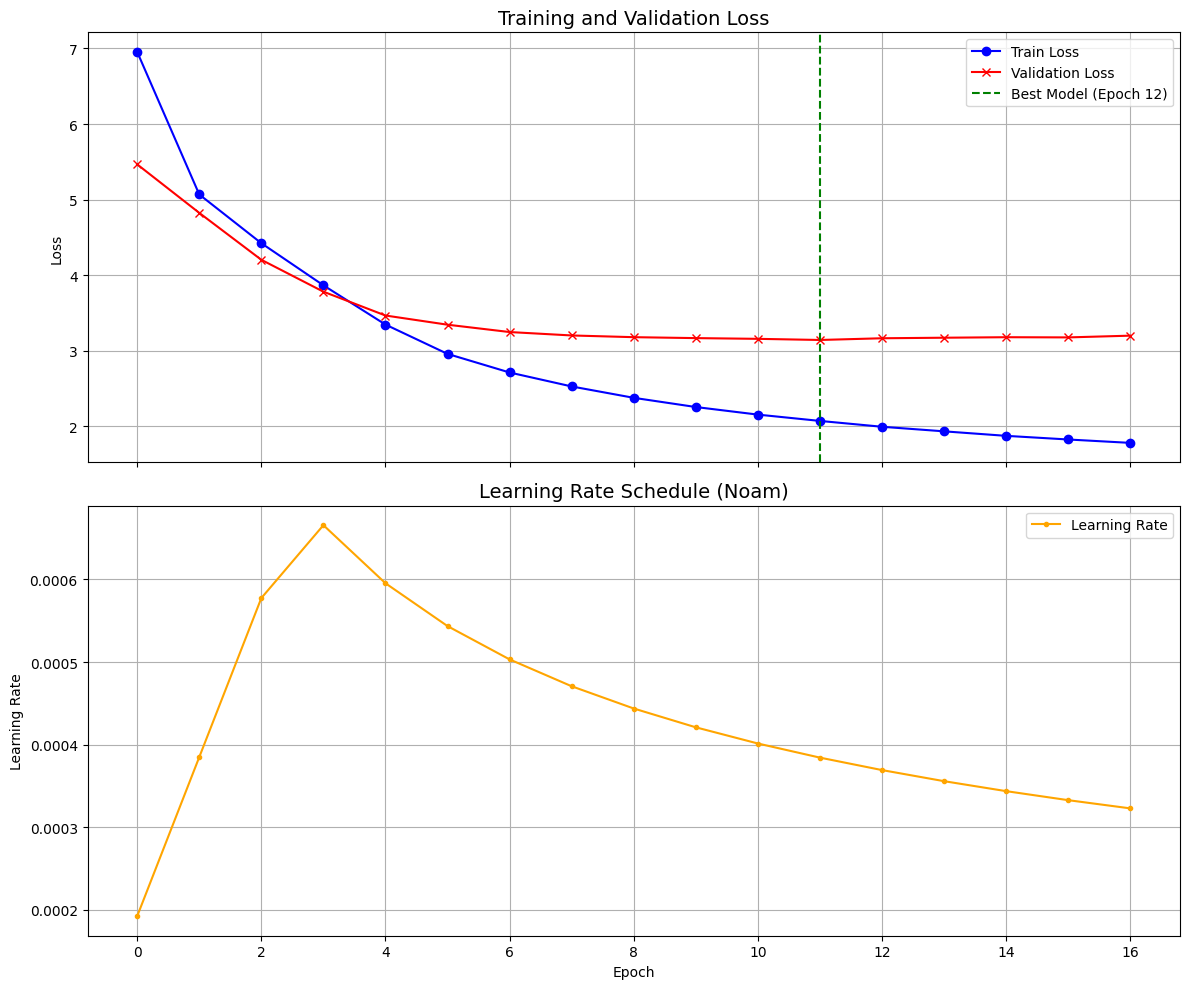

2025-11-11 16:32:46,634 - INFO - Starting BLEU evaluation on 100 random samples...



6. Running evaluation...


2025-11-11 16:34:23,284 - INFO - Successfully processed 100/100 samples for BLEU
2025-11-11 16:34:23,327 - INFO - BLEU score calculated: 8.53


BLEU Score: 8.53

Qualitative Analysis:
Example 1:
  Source (Irish): Measadh costais iomlána ar na billiúin euro .. dá bhrí sin an Pálás na Parlaiminte i mBúcairist is é sin, de réir Acadamh Taifead Domhanda, is daoire foirgneamh riaracháin ar fud an domhain.
  Reference (English): Total costs were estimated at . billions euros. Thus the Palace of Parliament in Bucharest is, according to World Record Academy, the most expensive administrative building in the world.
  Hypothesis (English):  total costs of the euro.. thus .. thus the palace of parliament in bucharest is, according to the global academy, in the case of a global record, the administrative building is the administrative building in the world.
  Similarity Score: 14.09 BLEU

Example 2:
  Source (Irish): Chonacthas dóibh go dtiocfadh siad as a chéile, go gcuirfidís timpeall ar a chorp agus go dtiocfadh siad ar ais ina dhiaidh, agus go dtéann sé i gcion ar cháithníní na n-atmaisféar fisiciúil eile a dtéann sé i dteagmháil leo,

In [10]:
import torch
import torch.nn as nn
import os
import json
from typing import List, Tuple 
import matplotlib.pyplot as plt
import statistics

# --- Make sure all your imports are in one cell ---
# from custom_tokenizer import BilingualTokenizer
# from model import TransformerModel
# from dataset import load_eubookshop_dataset, TranslationDataset
# from bpe_optimizer import BPEOptimizer
# from trainer import Trainer
# from evaluator import Evaluator
# from beam_search_decoder import BeamSearchDecoder
# ---

print("TRANSFORMER NMT SYSTEM FOR IRISH-ENGLISH TRANSLATION")
print("=" * 60)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Preparation ---
print("\n1. Loading and cleaning datasets...")
# ---
# CRITICAL FIX: The data loader now returns three distinct, pre-split tuples.
# ---
(train_ga, train_en), (val_ga, val_en), (test_ga, test_en) = load_eubookshop_dataset() 

# ---
# CRITICAL FIX: All manual splitting logic has been REMOVED.
# The splits from the data loader are used directly.
# ---
# split_idx = ... (REMOVED)
# train_ga, test_ga = ... (REMOVED)
# val_split_idx = ... (REMOVED)
# val_ga, train_ga = ... (REMOVED)

# Final dataset creation from the clean, pre-split lists
train_dataset = TranslationDataset(train_ga, train_en)
val_dataset = TranslationDataset(val_ga, val_en)
test_dataset = TranslationDataset(test_ga, test_en)
# --- END DATASET FIX ---

# --- (Dataset Statistics will now correctly report the splits) ---
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
print(f"Train dataset size:      {len(train_dataset):,}")
print(f"Validation dataset size: {len(val_dataset):,}")
print(f"Test dataset size:       {len(test_dataset):,}")
print(f"Total dataset size:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")
print("-" * 50)
# (Your print_sentence_stats function goes here)
# def print_sentence_stats(sentences: list, name: str): ...
print_sentence_stats(train_ga, "Train (Irish)")
print_sentence_stats(train_en, "Train (English)")
print_sentence_stats(val_ga, "Validation (Irish)")
print_sentence_stats(val_en, "Validation (English)")
print_sentence_stats(test_ga, "Test (Irish)")
print_sentence_stats(test_en, "Test (English)")
print("-" * 50)


# --- 2. BPE Optimization ---
print("\n2. Running BPE optimization...")
bpe_optimizer = BPEOptimizer(train_ga[:20000], train_en[:20000]) 
bpe_optimizer.evaluate_vocab_size(vocab_sizes=[i*2000 for i in range(15, 36)]) 
optimal_vocab_size = bpe_optimizer.get_optimal_vocab_size()
print(f"Optimal vocabulary size found: {optimal_vocab_size}")
bpe_optimizer.plot_results()


# --- 3. Tokenizer and Model Setup ---
print(f"\n3. Training tokenizers with optimal vocab size: {optimal_vocab_size}...")
tokenizer = BilingualTokenizer()
tokenizer.train(train_ga, train_en, vocab_size=optimal_vocab_size) 

print("\n4. Creating Transformer model...")
# Model parameters (small model for low-resource)
D_MODEL = 256
N_LAYERS = 4
DROPOUT = 0.2
N_HEAD = 8
DIM_FEEDFORWARD = 1024

model = TransformerModel(
    src_vocab_size=tokenizer.src_vocab_size,
    tgt_vocab_size=tokenizer.tgt_vocab_size,
    d_model=D_MODEL,
    nhead=N_HEAD,
    num_encoder_layers=N_LAYERS,
    num_decoder_layers=N_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

trainer = Trainer(model, tokenizer, device)

# --- 5. Training Setup ---
PAD_IDX = tokenizer.pad_token_id
BATCH_SIZE = 32
EPOCHS = 100 # Your max
PATIENCE = 5 # Your patience

# --- Using Noam Scheduler ---
WARMUP_STEPS = 8000 
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)

# --- Checkpointing Variables ---
best_val_loss = float('inf')
epochs_no_improve = 0
checkpoint_path = "best_transformer_weights.pth"
global_step = 0 

# --- History lists for plotting ---
train_loss_history = []
val_loss_history = []
lr_history = []

# --- 6. MODEL TRAINING ---
print(f"\n5. Starting Model Training for up to {EPOCHS} epochs with patience={PATIENCE}...")
print(f"Using Noam LR Scheduler with {WARMUP_STEPS} warmup steps.")

# Setup DataLoaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(1, EPOCHS + 1):
    
    # Training Phase
    train_loss, new_global_step = trainer.train_epoch(
        train_dataloader, 
        optimizer, 
        criterion, 
        D_MODEL,
        WARMUP_STEPS,
        global_step,
        clip=1.0
    )
    global_step = new_global_step

    # Validation Phase
    val_loss = trainer.validate_epoch(val_dataloader, criterion) 
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} Results: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.7f}")
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    lr_history.append(current_lr)
    
    # --- Early Stopping and Checkpointing Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"--> Checkpoint saved at Epoch {epoch} with new best loss: {best_val_loss:.4f}")
    else:
        epochs_no_improve += 1
        print(f"--> Validation loss did not improve. Patience: {epochs_no_improve}/{PATIENCE}")
        
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at Epoch {epoch}. Loading best model weights.")
            break

# --- Final Load of Best Model Weights ---
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded best model weights from {checkpoint_path}.")
else:
    print("No checkpoint found. Using last trained weights.")
    

# --- PLOTTING ---
print("\n8. Plotting training history...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Training and Validation Loss
ax1.plot(train_loss_history, label='Train Loss', color='blue', marker='o')
ax1.plot(val_loss_history, label='Validation Loss', color='red', marker='x')
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
if best_val_loss != float('inf'):
    best_epoch = val_loss_history.index(min(val_loss_history))
    ax1.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    ax1.legend()

# Plot 2: Learning Rate
ax2.plot(lr_history, label='Learning Rate', color='orange', marker='.')
ax2.set_title('Learning Rate Schedule (Noam)', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

# --- 7. Evaluation ---
print("\n6. Running evaluation...")
evaluator = Evaluator(model, tokenizer, test_dataset)
bleu_score, references, hypotheses, sources = evaluator.evaluate_bleu(num_samples=100)
print(f"BLEU Score: {bleu_score:.2f}")
evaluator.qualitative_analysis(num_examples=10)
evaluator.error_analysis(sources, references, hypotheses)

# --- 8. Save Final Model ---
print("\n7. Saving model...")
def save_model_and_tokenizer(model, tokenizer, save_path):
    os.makedirs(save_path, exist_ok=True)
    model_path = os.path.join(save_path, "transformer_nmt_model.pth")
    torch.save(model.state_dict(), model_path)
    tokenizer_path = os.path.join(save_path, "tokenizer_config.json")
    config = {
        'src_vocab_size': tokenizer.src_vocab_size,
        'tgt_vocab_size': tokenizer.tgt_vocab_size,
        'optimal_vocab_size_used': tokenizer.src_tokenizer.get_vocab_size()
    }
    with open(tokenizer_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, ensure_ascii=False, indent=2)
    print(f"Model saved to: {model_path}")
    print(f"Tokenizer config saved to: {tokenizer_path}")
    
save_model_and_tokenizer(model, tokenizer, "saved_model_irish_english")

print("\n" + "="*70)
print("TRANSFORMER NMT SYSTEM IMPLEMENTATION COMPLETE")
# ... (rest of file is unchanged) ...

In [20]:
# --- 7. Evaluation ---
print("\n6. Running evaluation...")
evaluator = Evaluator(model, tokenizer, test_dataset)
bleu_score, references, hypotheses, sources = evaluator.evaluate_bleu(num_samples=100)
print(f"BLEU Score: {bleu_score:.2f}")
evaluator.qualitative_analysis(num_examples=10)
evaluator.error_analysis(sources, references, hypotheses)

# --- 8. Save Final Model ---
print("\n7. Saving model...")
def save_model_and_tokenizer(model, tokenizer, save_path):
    os.makedirs(save_path, exist_ok=True)
    model_path = os.path.join(save_path, "transformer_nmt_model.pth")
    torch.save(model.state_dict(), model_path)
    tokenizer_path = os.path.join(save_path, "tokenizer_config.json")
    config = {
        'src_vocab_size': tokenizer.src_vocab_size,
        'tgt_vocab_size': tokenizer.tgt_vocab_size,
        'optimal_vocab_size_used': tokenizer.src_tokenizer.get_vocab_size()
    }
    with open(tokenizer_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, ensure_ascii=False, indent=2)
    print(f"Model saved to: {model_path}")
    print(f"Tokenizer config saved to: {tokenizer_path}")
    
save_model_and_tokenizer(model, tokenizer, "saved_model_irish_english")

print("\n" + "="*70)
print("TRANSFORMER NMT SYSTEM IMPLEMENTATION COMPLETE")
# ... (rest of file is unchanged) ...

2025-11-11 20:44:26,961 - INFO - Generating new evaluation sample of 100 items...



6. Running evaluation...


2025-11-11 20:46:15,406 - INFO - Successfully processed 100/100 samples.
2025-11-11 20:46:15,416 - INFO - BLEU score calculated: 23.15


BLEU Score: 23.15

Qualitative Analysis:
Example 1 (from BLEU sample):
  Source (Irish): ní cháilítear daoine ag a bhfuil Cárta cuairte LG , Cárta faoin Scéim íoctha Drugaí , Cárta Eorpach um árachas Sláinte nó Cárta faoin Scéim tinnis Fhadtéarmaigh don ráta laghdaithe .
  Reference (English): people who hold a GP Visit card , a Drugs payment Scheme card , a European Health Insurance card or a long-term illness Scheme card do not qualify for the reduced rate .
  Hypothesis (English):  a gp visit card has not been treated as a gp visit card , a european health insurance card or a card under long term for the reduced rate .
  Similarity Score: 19.00 BLEU

Example 2 (from BLEU sample):
  Source (Irish): Dúradh Is Maith Díchoisc Díchoisc Ar Feitheamh Iarratas leanúna ó ar feitheamh Cuir ar ceal Cealaigh d'iarratas leanúna do Tuilleadh
  Reference (English): Follow Follow Following Following Unfollow follow request from Cancel Cancel your follow request to More
  Hypothesis (English):  foll

In [21]:
# --- 7. Evaluation ---
print("\n6. Running evaluation...")
evaluator = Evaluator(model, tokenizer, test_dataset)

# --- START: CRITICAL FIX ---
# Do not use a small sample. Use the *entire* test set for the final score.
# This will be slower, but it will be 100% accurate and reproducible.
print(f"Evaluating on the full test set of {len(test_dataset)} samples...")
bleu_score, references, hypotheses, sources = evaluator.evaluate_bleu(num_samples=len(test_dataset))
# --- END: CRITICAL FIX ---

print(f"FINAL BLEU SCORE: {bleu_score:.2f}")

# The qualitative analysis can still just show the first 10
evaluator.qualitative_analysis(num_examples=10) 
evaluator.error_analysis(sources, references, hypotheses)

# ... (rest of your file) ...

2025-11-11 20:46:16,417 - INFO - Generating new evaluation sample of 6530 items...



6. Running evaluation...
Evaluating on the full test set of 6530 samples...


2025-11-11 20:48:03,300 - INFO - Attempted 100/6530 samples (Succeeded: 100)...
2025-11-11 20:49:38,939 - INFO - Attempted 200/6530 samples (Succeeded: 200)...
2025-11-11 20:51:22,751 - INFO - Attempted 300/6530 samples (Succeeded: 300)...
2025-11-11 20:53:08,063 - INFO - Attempted 400/6530 samples (Succeeded: 400)...
2025-11-11 20:55:01,026 - INFO - Attempted 500/6530 samples (Succeeded: 500)...
2025-11-11 20:56:44,221 - INFO - Attempted 600/6530 samples (Succeeded: 600)...
2025-11-11 20:58:26,051 - INFO - Attempted 700/6530 samples (Succeeded: 700)...
2025-11-11 21:00:09,337 - INFO - Attempted 800/6530 samples (Succeeded: 800)...
2025-11-11 21:01:47,109 - INFO - Attempted 900/6530 samples (Succeeded: 900)...
2025-11-11 21:03:31,628 - INFO - Attempted 1000/6530 samples (Succeeded: 1000)...
2025-11-11 21:05:06,924 - INFO - Attempted 1100/6530 samples (Succeeded: 1100)...
2025-11-11 21:06:55,625 - INFO - Attempted 1200/6530 samples (Succeeded: 1200)...
2025-11-11 21:08:41,917 - INFO - A

FINAL BLEU SCORE: 34.21

Qualitative Analysis:
Example 1 (from BLEU sample):
  Source (Irish): "() Go gceapfar Roghchoiste ar a mbeidh comhalta de Sheanad Éireann (nach comhalta den Rialtas ná Aire Stáit aon duine díobh) a bheidh le comhcheangal le Roghchoiste a cheapfaidh Dáil Éireann le Comhchoiste a fhoirmiú (dá ngairfear an Comhchoiste um Chomhlachtaí Stát-Tionscanta) chun scrúdú a dhéanamh ar Thuarascálacha agus Cuntais agus torthaí oibríochta i gcoitinne comhlachtaí Stát-tionscanta atá ag gabháil do ghníomhaíochtaí trádála nó tráchtála dá dtagraítear i Sceideal A a ghabhann leis seo agus ar ghnéithe trádála agus/nó tráchtála na dTuarascálacha agus na gCuntas agus torthaí oibríochta i gcoitinne an chomhlachta Stát-tionscanta dá dtagraítear i Sceideal B a ghabhann leis seo agus tuarascáil a thabhairt ina dtaobh sin do dhá Theach an Oireachtais agus moltaí a dhéanamh más cuí.
  Reference (English): () That a Select Committee consisting of members of Seanad Éireann (none of whom shal

# End